# Load the gmm trained

In [ ]:
# Notebook-friendly imports
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
from types import SimpleNamespace

import torch

# our utils
from utils import (
    get_dataset, build_model, eval_acc, parse_batch_spec,
    build_encoder, load_decoder_backend, g_ball
)
from fit_gmm import GMM  # our GMM class (including compute_pr_on_clean_correct)

# path to GMM package & classifier ckpt
PKG_PATH  = "./log/gmm_ckp/x_dep/gmm_CWlike_resnet18_cifar10_cov(lowrank)_L(l2_0p2500)_K(7).pt"
CLF_CKPT  = "./model_zoo/trained_model/sketch/resnet18_cifar10.pth"

# optional settings
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
S_SAMPLES = 10        # PR number of MC samples per image
BATCH_IDX = ""         # the batch index，e.g. "0,3,5-10"；"" means all batches
BATCH_SIZE= 128        # the batch size for the evaluation DataLoader

device = torch.device(DEVICE)

if not os.path.isfile(PKG_PATH):
    raise FileNotFoundError(PKG_PATH)

# let out_shape=None first，refill out_shape later after we load dataset
# (because out_shape depends on dataset)
gmm, enc_loaded, dec_loaded, meta = GMM.load_package(
    filepath=PKG_PATH,
    device=device,
    build_encoder_fn=build_encoder,
    load_decoder_backend_fn=load_decoder_backend,
    out_shape=None
)

# use snapshot to rebuild dataset, model, feat_extractor
snap = meta.get("args_snapshot") or {}
eva  = SimpleNamespace(**snap)  # eva.dataset / eva.arch / eva.gamma / eva.norm / ...

# addtional settings (override snapshot) for classfier ckpt & eval
clf_ckpt = getattr(eva, "clf_ckpt", None) or CLF_CKPT
print("Loaded package:", PKG_PATH)
print("Snapshot keys:", list(snap.keys()))

# load dataset

In [ ]:
dataset, num_classes, out_shape = get_dataset(eva.dataset, train=False)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)
print("Dataset:", eva.dataset, "num_classes:", num_classes, "out_shape:", out_shape)


Files already downloaded and verified
Dataset: cifar10 num_classes: 10 out_shape: (3, 32, 32)


# Load classifiers check-point

In [3]:
model, feat_extractor = build_model(eva.arch, num_classes, device)

# load classifier ckpt
state = torch.load(clf_ckpt, map_location="cpu", weights_only=False)
if "state_dict" in state:
    state = state["state_dict"]
state = {k.replace("module.", ""): v for k, v in state.items()}
missing, unexpected = model.load_state_dict(state, strict=False)
print(f"[clf] loaded. missing={len(missing)} unexpected={len(unexpected)}")

# freeze & eval()
model = model.to(device).eval();  [p.requires_grad_(False) for p in model.parameters()]
feat_extractor = feat_extractor.to(device).eval(); [p.requires_grad_(False) for p in feat_extractor.parameters()]

# check accuracy on clean data
acc_clean = eval_acc(model, dataset, device)
print(f"[clean acc] {acc_clean*100:.2f}%")

[clf] loaded. missing=0 unexpected=0


[clf] accuracy=86.78%
[clean acc] 86.78%


# Compute PR

In [4]:
from utils import compute_pr_on_clean_correct_old
# whether use encoder & decoder and xdep
# all from the loaded GMM package
xdep        = meta["gmm_config"]["xdep"] 
use_decoder = meta["decoder_info"].get("use_decoder", False)
encoder_for_eval = enc_loaded if xdep else None
decoder_for_eval = dec_loaded if use_decoder else None

# the batch to be evaluated
pr_sel = parse_batch_spec(BATCH_IDX)

# compute PR (on clean correct samples)


pr, n_used, clean_acc = gmm.compute_pr_on_clean_correct(
    model=model,
    loader=loader,
    out_shape=out_shape,
    encoder=encoder_for_eval,
    decoder=decoder_for_eval,
    S=S_SAMPLES,
    gamma=eva.gamma,          # from training snapshot
    norm_type=eva.norm,       # from training snapshot
    use_decoder=use_decoder,
    batch_indices=pr_sel
)
print(f"[PR] used={n_used}  clean-acc={clean_acc*100:.2f}%  PR={pr:.4f}")


RuntimeError: GMM.compute_pr_on_clean_correct: self.xdep=True but encoder is None.

# Visualization 
## 1. Inputs independent results 

In [33]:
from utils.viz_gmm import cov_to_full, plot_tensor_bars
import matplotlib.colors as mcolors

blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white", ["navy", "white"]   # 起点 navy 深蓝, 终点白色
)


feat = torch.empty(1, 0, device=device) # for x-indep GMM
# (1,0) because head expects a batch dimension

pi_b, mu_b, cov_b = gmm(feat) # pi:(1,K), mu:(1,K,D)
pi = pi_b[0]
mu = mu_b[0] 

K = pi.shape[0] # number of components
D = mu.shape[1] # feature dimension

# for full Sigma setup
if gmm.cov_type == "diag":
    Sigma = cov_to_full(cov_b[0], "diag") # (K,D,D)
elif gmm.cov_type == "full":
    Sigma = cov_to_full(cov_b[0], "full")
else:
    U, sigma = cov_b
    Sigma = cov_to_full((U[0], sigma[0]), "lowrank")

pi.shape, mu.shape, Sigma.shape  # (K,), (K,D), (K,D,D)

(torch.Size([7]), torch.Size([7, 3072]), torch.Size([7, 3072, 3072]))

(<Figure size 395x320 with 1 Axes>,
 <Axes: title={'center': 'Mixture weights $\\pi$'}, xlabel='Component $k$', ylabel='$\\pi_k$'>)

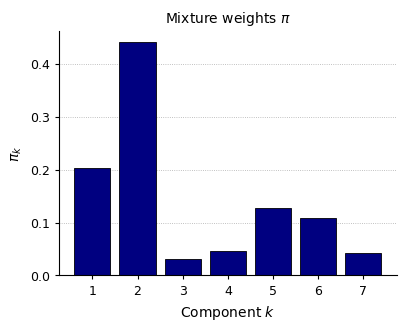

In [34]:
plot_tensor_bars(pi, xticks_step=1, 
                 titles=r"Mixture weights $\pi$", 
                 ylabel=r"$\pi_k$", 
                 xlabel=r"Component $k$",
                 color="navy")

### PCA for distributions 

In [35]:
from utils.viz_gmm import pick_projection
proj, proj_2d = pick_projection(Sigma, pi, max_dim=32)  # (D,d) (D,2)

# projection for each component
mu_proj = mu @ proj        # (K,d)
Sigma_proj = torch.stack([proj.t() @ Sigma[k] @ proj for k in range(K)], dim=0)  # (K,d,d)

# 2-d projection for contour plot
mu_proj_2d = mu @ proj_2d  # (K,2)
Sigma_proj_2d = torch.stack([proj_2d.T @ Sigma[k] @ proj_2d for k in range(K)], dim=0)  # (K,2,2)


(<Figure size 900x780 with 7 Axes>,
 array([[<Axes: title={'center': 'K=1'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=2'}>, <Axes: title={'center': 'K=3'}>],
        [<Axes: title={'center': 'K=4'}, ylabel='$\\mu$'>,
         <Axes: title={'center': 'K=5'}>, <Axes: title={'center': 'K=6'}>],
        [<Axes: title={'center': 'K=7'}, ylabel='$\\mu$'>, <Axes: >,
         <Axes: >]], dtype=object))

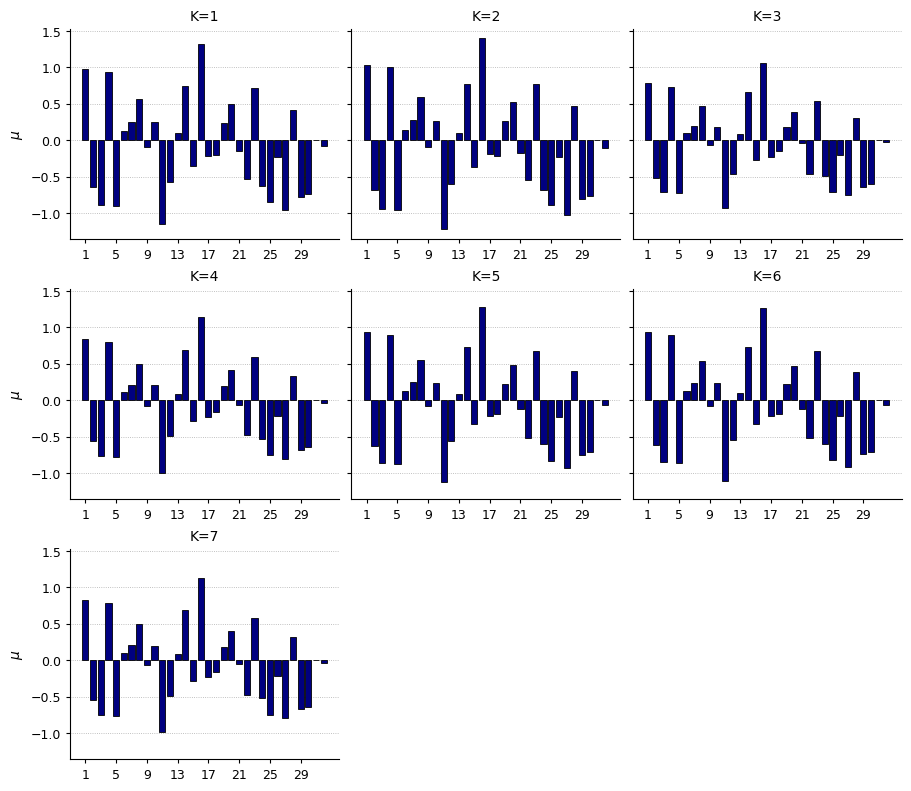

In [36]:
plot_tensor_bars(mu_proj, xticks_step=4, 
                 titles=[f"K={i+1}" for i in range(K)], 
                 ylabel=r"$\mu$",
                 color="navy")

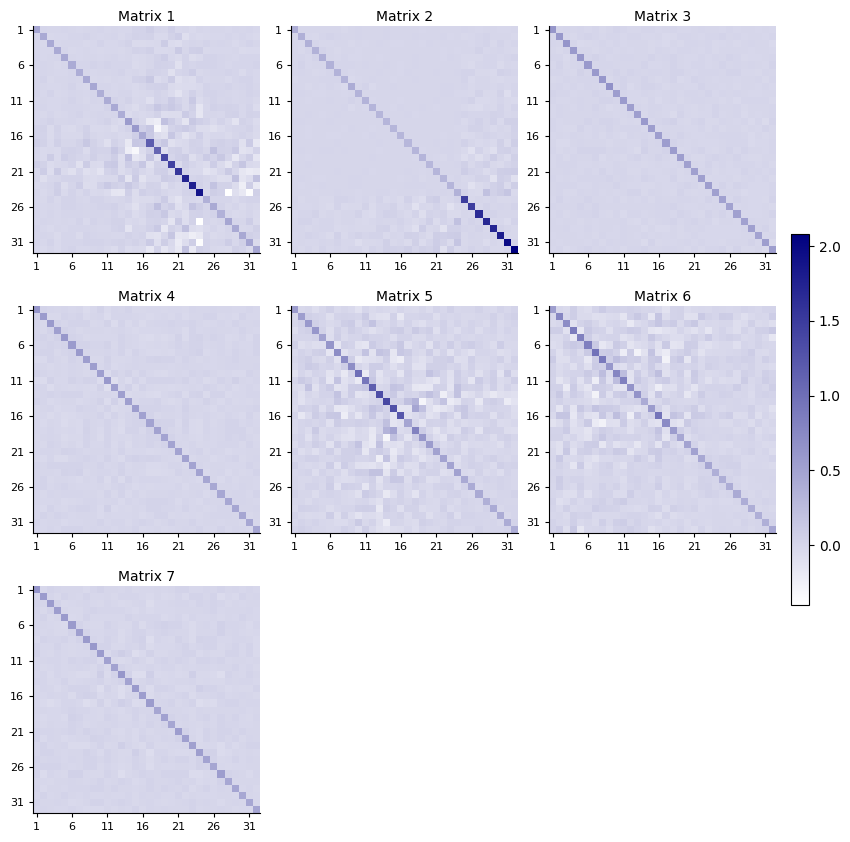

In [37]:
import matplotlib.colors as mcolors
from utils.viz_gmm import plot_tensor_heatmaps
import matplotlib.pyplot as plt

blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "blue_white", ["navy", "white"]   # 起点 navy 深蓝, 终点白色
)

plot_tensor_heatmaps(
    Sigma_proj,
    titles=[rf"$\Sigma_{i+1}$" for i in range(3)],
    nrows=3, ncols=3,        # 手动 1 行 3 列
    reverse_cmap=True,       # 颜色对调
    share_color=True,
    xtick_step=5,
    cmap=blue_cmap
)
plt.show()


In [27]:
pi, mu_proj_2d, Sigma_proj_2d  # (K,), (K,2), (K,2,2)

(tensor([0.1081, 0.6123, 0.2796], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([[ 0.2668, -1.0859],
         [ 0.2487, -1.2704],
         [ 0.2588, -1.2024]], device='cuda:0', grad_fn=<MmBackward0>),
 tensor([[[ 4.8013e-01,  1.1934e-02],
          [ 1.1934e-02,  4.7003e-01]],
 
         [[ 2.0441e+00, -8.2895e-04],
          [-8.2895e-04,  2.2417e+00]],
 
         [[ 4.6027e-01, -2.7993e-03],
          [-2.7993e-03,  4.9589e-01]]], device='cuda:0',
        grad_fn=<StackBackward0>))

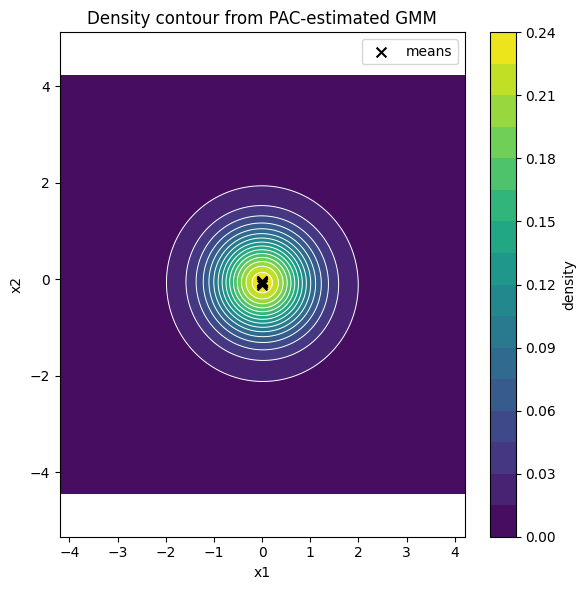

In [38]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import Categorical, MultivariateNormal, MixtureSameFamily

# 1) 把参数挪到 CPU（绘图要用 numpy），并确保协方差对称
pi    = pi.detach().cpu()
mu    = mu_proj_2d.detach().cpu()           # (K, 2)
Sigma = Sigma_proj_2d.detach().cpu()        # (K, 2, 2)
Sigma = 0.5 * (Sigma + Sigma.transpose(-1, -2))

# 2) 构造 GMM
mix = Categorical(probs=pi)
components = MultivariateNormal(loc=mu, covariance_matrix=Sigma)
gmm = MixtureSameFamily(mix, components)

# 3) 自适应取网格范围：所有均值的 ±3σ 覆盖
diag_std = Sigma.diagonal(dim1=-2, dim2=-1).sqrt()     # (K,2)
lo = (mu - 3*diag_std).min(0).values
hi = (mu + 3*diag_std).max(0).values

nx = ny = 400
x = torch.linspace(lo[0].item(), hi[0].item(), nx)
y = torch.linspace(lo[1].item(), hi[1].item(), ny)
X, Y = torch.meshgrid(x, y, indexing="xy")
grid = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)

with torch.no_grad():
    Z = gmm.log_prob(grid).exp().reshape(nx, ny)  # 密度

# 4) 画等高线
plt.figure(figsize=(6,6))
cs = plt.contourf(X.numpy(), Y.numpy(), Z.numpy(), levels=20)
plt.contour(X.numpy(), Y.numpy(), Z.numpy(), levels=20, linewidths=0.7, colors="white")
plt.scatter(mu[:,0], mu[:,1], s=50, c="k", marker="x", label="means")
plt.legend(loc="upper right")
plt.colorbar(cs, label="density")
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Density contour from PAC-estimated GMM")
plt.axis("equal")
plt.tight_layout()
plt.show()
